In [10]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-5371946b-bc7a-8404-76f2-94eebc42c1b7)


In [11]:
!tree -d ../../images/png

../../images/png
├── Collection1
│   └── BAYC
└── Collection2
    └── EAPES

4 directories


In [12]:
!pip3 install numpy -q
!pip3 install torch -q
!pip3 install torchvision -q
!pip3 install matplotlib -q
!pip3 install tqdm -q
!pip3 install ipywidgets -q
!pip3 install opencv-python -q

In [13]:
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [14]:
# Set random seed for reproducibility
# manualSeed = 42
manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  4231


In [15]:
class DCGAN_2D(nn.Module):

    def __init__(
        self,                   
        dataroot1,              # Root directory for dataset 1
        dataroot2,              # Root directory for dataset 2
        logfolder,
        weight1 = 0.5,          # Weight dataset 1
        weight2 = 0.5,          # Weight dataset 2
        workers = 2,            # Number of workers for dataloader
        batch_size = 128,       # Batch size during training
        image_size = 64,        # Spatial size of training images. All images will be resized to this size using a transformer.
        nc = 3,                 # Number of channels in the training images. For color images this is 3
        nz = 100,               # Size of z latent vector (i.e. size of generator input)
        ngf = 64,               # Size of feature maps in generator
        ndf = 64,               # Size of feature maps in discriminator
        num_epochs = 100,       # Number of training epochs
        lr = 0.0002,            # Learning rate for optimizers
        beta1 = 0.5,            # Beta1 hyperparam for Adam optimizers
        ngpu = 1                # Number of GPUs available. Use 0 for CPU mode.
        ):
        super(DCGAN_2D, self).__init__()
        self.logfolder = logfolder
        # Hyperparameters etc.
        self.weight1 = weight1
        self.weight2 = weight2
        self.device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
        self.LEARNING_RATE = lr  # could also use two lrs, one for gen and one for disc
        self.BATCH_SIZE = batch_size
        self.IMAGE_SIZE = image_size
        self.CHANNELS_IMG = nc
        self.NOISE_DIM = nz
        self.NUM_EPOCHS = num_epochs
        self.FEATURES_DISC = ndf
        self.FEATURES_GEN = ngf
        self.BETA = beta1

        self.transform = transforms.Compose(
            [
                transforms.Resize((self.IMAGE_SIZE, self.IMAGE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.5 for _ in range(self.CHANNELS_IMG)], [0.5 for _ in range(self.CHANNELS_IMG)]
                ),
            ]
        )
        #DATASETS IN DATAROOTS MUST HAVE THE SAME SIZE OF THE FIRST DIMENTION
        dataset1 = datasets.ImageFolder(root=dataroot1, transform=self.transform)
        dataset2 = datasets.ImageFolder(root=dataroot2, transform=self.transform)
        self.dataloader1 = DataLoader(dataset1, batch_size=self.BATCH_SIZE, shuffle=True, num_workers=workers)
        self.dataloader2 = DataLoader(dataset2, batch_size=self.BATCH_SIZE, shuffle=True, num_workers=workers)
        self.dataloader = list(zip(self.dataloader1, self.dataloader2))
        self.gen = self.Generator(self.NOISE_DIM, self.CHANNELS_IMG, self.FEATURES_GEN).to(self.device)
        self.disc1 = self.Discriminator(self.CHANNELS_IMG, self.FEATURES_DISC).to(self.device)
        self.disc2 = self.Discriminator(self.CHANNELS_IMG, self.FEATURES_DISC).to(self.device)
        if (self.device.type == 'cuda') and (ngpu > 1):
            self.gen = nn.DataParallel(self.gen, list(range(ngpu)))
            self.disc1 = nn.DataParallel(self.disc1, list(range(ngpu)))
            self.disc2 = nn.DataParallel(self.disc2, list(range(ngpu)))
        self.gen.apply(self.weights_init)
        self.disc1.apply(self.weights_init)
        self.disc2.apply(self.weights_init)

        # Initialize BCELoss function
        self.criterion = nn.BCELoss()
        # Create batch of latent vectors that we will use to visualize the progression of the generator
        self.fixed_noise = torch.randn(64, self.NOISE_DIM, 1, 1, device=self.device)
        # Establish convention for real and fake labels during training
        self.real_label = 1.
        self.fake_label = 0.
        # Setup Adam optimizers for both G and D
        self.opt_gen = optim.Adam(self.gen.parameters(), lr=self.LEARNING_RATE, betas=(self.BETA, 0.999))
        self.opt_disc1 = optim.SGD(self.disc1.parameters(), lr=self.LEARNING_RATE)
        self.opt_disc2 = optim.SGD(self.disc2.parameters(), lr=self.LEARNING_RATE)

    def weights_init(self, model):
        # Initializes weights according to the DCGAN paper
        for m in model.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif isinstance(m, (nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
                nn.init.constant_(m.bias.data, 0)

    def train(self):

        # Training Loop

        # Lists to keep track of progress
        img_list = []
        G_losses = []
        G1_losses = []
        G2_losses = []
        D1_losses = []
        D2_losses = []

        toPrintEpoch = list(range(0, self.NUM_EPOCHS, max((self.NUM_EPOCHS // 100), 1)))

        # For each epoch
        for epoch in tqdm(range(self.NUM_EPOCHS)):
            # For each batch in the dataloader
            for (data1, data2) in self.dataloader:

                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################
                ## Train with all-real batch
                self.disc1.zero_grad()
                self.disc2.zero_grad()
                # Format batch
                real1_cpu = data1[0].to(self.device)
                b1_size = real1_cpu.size(0)
                label1 = torch.full((b1_size,), self.real_label, dtype=torch.float, device=self.device)
                real2_cpu = data2[0].to(self.device)
                b2_size = real2_cpu.size(0)
                label2 = torch.full((b2_size,), self.real_label, dtype=torch.float, device=self.device)
                # Forward pass real batch through D
                output1 = self.disc1(real1_cpu).view(-1)
                output2 = self.disc2(real2_cpu).view(-1)
                # Calculate loss on all-real batch
                errD1_real = self.criterion(output1, label1)
                errD2_real = self.criterion(output2, label2)
                # Calculate gradients for D in backward pass
                errD1_real.backward()
                D1_x = output1.mean().item()
                errD2_real.backward()
                D2_x = output2.mean().item()

                ## Train with all-fake batch
                # Generate batch of latent vectors
                b_size = (b1_size + b2_size) // 2
                noise = torch.randn(b_size, self.NOISE_DIM, 1, 1, device=self.device)
                # Generate fake image batch with G
                fake = self.gen(noise)
                label1.fill_(self.fake_label)
                label2.fill_(self.fake_label)
                # Classify all fake batch with D
                output1 = self.disc1(fake.detach()).view(-1)
                output2 = self.disc2(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                errD1_fake = self.criterion(output1, label1)
                errD2_fake = self.criterion(output2, label2)
                # Calculate the gradients for this batch, accumulated (summed) with previous gradients
                errD1_fake.backward()
                D1_G_z1 = output1.mean().item()
                errD2_fake.backward()
                D2_G_z1 = output2.mean().item()
                # Compute error of D as sum over the fake and the real batches
                errD1 = errD1_real + errD1_fake
                errD2 = errD2_real + errD2_fake
                # Update D
                self.opt_disc1.step()
                self.opt_disc2.step()

                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################
                self.gen.zero_grad()
                label1.fill_(self.real_label)  # fake labels are real for generator cost
                label2.fill_(self.real_label)  # fake labels are real for generator cost
                label = torch.full((b1_size,), self.real_label, dtype=torch.float, device=self.device)
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output1 = self.disc1(fake).view(-1)
                output2 = self.disc2(fake).view(-1)
                output = torch.min(output1, output2)
                # output = torch.max(output1, output2)
                # output = torch.abs(output1 - output2)
                # output = (output1 + output2) / 2
                # Calculate G's loss based on this output
                errG1 = self.criterion(output1, label1) 
                errG2 = self.criterion(output2, label2) 
                errG = self.criterion(output, label) / 2
                # Calculate gradients for G
                errG.backward()
                D1_G_z2 = output1.mean().item()
                D2_G_z2 = output2.mean().item()
                # Update G
                self.opt_gen.step()

                # Save Losses for plotting later
                G_losses.append(errG.mean().item())
                G1_losses.append(errG1.mean().item())
                G2_losses.append(errG2.mean().item())
                D1_losses.append(errD1.mean().item())
                D2_losses.append(errD2.mean().item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (epoch in toPrintEpoch):
                with torch.no_grad():
                    no_grad_fake = self.gen(self.fixed_noise).detach().cpu()
                    
                img_grid_fake = vutils.make_grid(no_grad_fake, padding=2, normalize=True)
                
                plt.figure(figsize=(15,15))
                plt.axis("off")
                plt.imshow(np.transpose(img_grid_fake,(1,2,0)))
                plt.savefig("{}/{}.png".format(self.logfolder, epoch+1))
                plt.close()

                img_list.append(img_grid_fake)



        return img_list, G_losses, G1_losses, G2_losses, D1_losses, D2_losses

    class Discriminator(nn.Module):
        def __init__(self, channels_img, features_d):
            super(DCGAN_2D.Discriminator, self).__init__()
            self.disc = nn.Sequential(
                # input: N x channels_img x 64 x 64
                nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.2),
                # _block(in_channels, out_channels, kernel_size, stride, padding)
                self._block(features_d, features_d * 2, 4, 2, 1),
                self._block(features_d * 2, features_d * 4, 4, 2, 1),
                self._block(features_d * 4, features_d * 8, 4, 2, 1),
                # After all _block img output is 4x4 (Conv2d below makes into 1x1)
                nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
                nn.Sigmoid(),
            )

        def _block(self, in_channels, out_channels, kernel_size, stride, padding):
            return nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size,
                    stride,
                    padding,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2),
            )

        def forward(self, x):
            return self.disc(x)


    class Generator(nn.Module):
        def __init__(self, channels_noise, channels_img, features_g):
            super(DCGAN_2D.Generator, self).__init__()
            self.net = nn.Sequential(
                # Input: N x channels_noise x 1 x 1
                self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
                self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
                self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
                self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
                nn.ConvTranspose2d(
                    features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
                ),
                # Output: N x channels_img x 64 x 64
                nn.Tanh(),
            )

        def _block(self, in_channels, out_channels, kernel_size, stride, padding):
            return nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels,
                    out_channels,
                    kernel_size,
                    stride,
                    padding,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )

        def forward(self, x):
            return self.net(x)

In [16]:
collection = "Collection_1_2"
num_epochs = 10
!mkdir $collection

mkdir: cannot create directory ‘Collection_1_2’: File exists


In [17]:
modelDCGAN_2D = DCGAN_2D('../../images/png/Collection1', '../../images/png/Collection2', collection, num_epochs=num_epochs)

In [18]:
img_list, G_losses, G1_losses, G2_losses, D1_losses, D2_losses = modelDCGAN_2D.train()

100%|██████████| 10/10 [01:12<00:00,  7.24s/it]


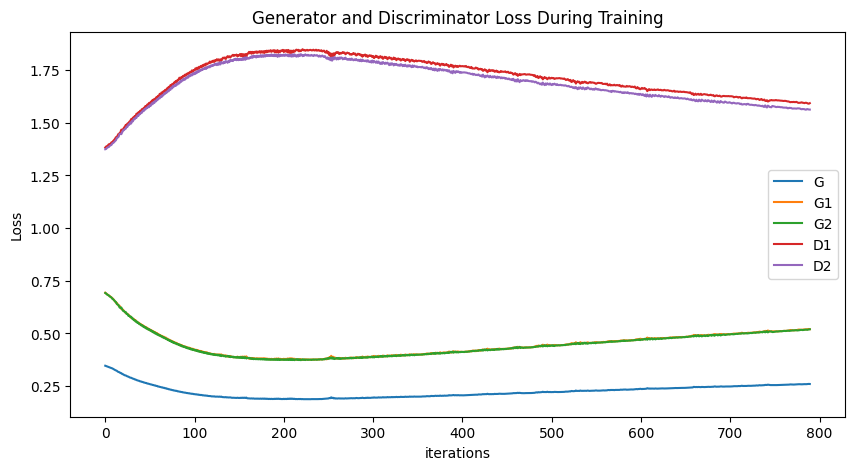

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(G1_losses,label="G1")
plt.plot(G2_losses,label="G2")
plt.plot(D1_losses,label="D1")
plt.plot(D2_losses,label="D2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('{}/loss.png'.format(collection))
plt.show()

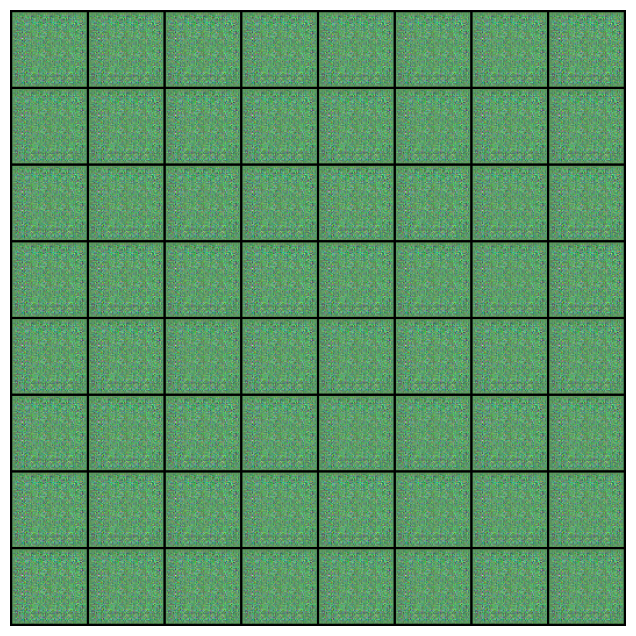

In [20]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[::10]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [21]:
# Grab a batch of real images from the dataloader
real1_batch = next(iter(modelDCGAN_2D.dataloader1))
real2_batch = next(iter(modelDCGAN_2D.dataloader2))

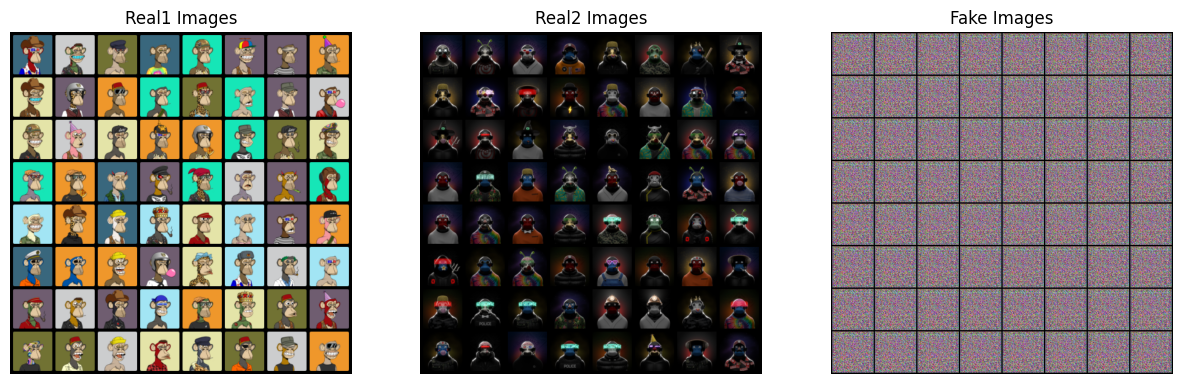

In [22]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("Real1 Images")
plt.imshow(np.transpose(vutils.make_grid(real1_batch[0].to(modelDCGAN_2D.device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,3,2)
plt.axis("off")
plt.title("Real2 Images")
plt.imshow(np.transpose(vutils.make_grid(real2_batch[0].to(modelDCGAN_2D.device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,3,3)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('{}/result.png'.format(collection))
plt.show()

In [23]:
with open('{}/gen'.format(collection), 'wb') as f:
    pickle.dump(modelDCGAN_2D.gen, f)
with open('{}/disc1'.format(collection), 'wb') as f:
    pickle.dump(modelDCGAN_2D.disc1, f)
with open('{}/disc2'.format(collection), 'wb') as f:
    pickle.dump(modelDCGAN_2D.disc2, f)

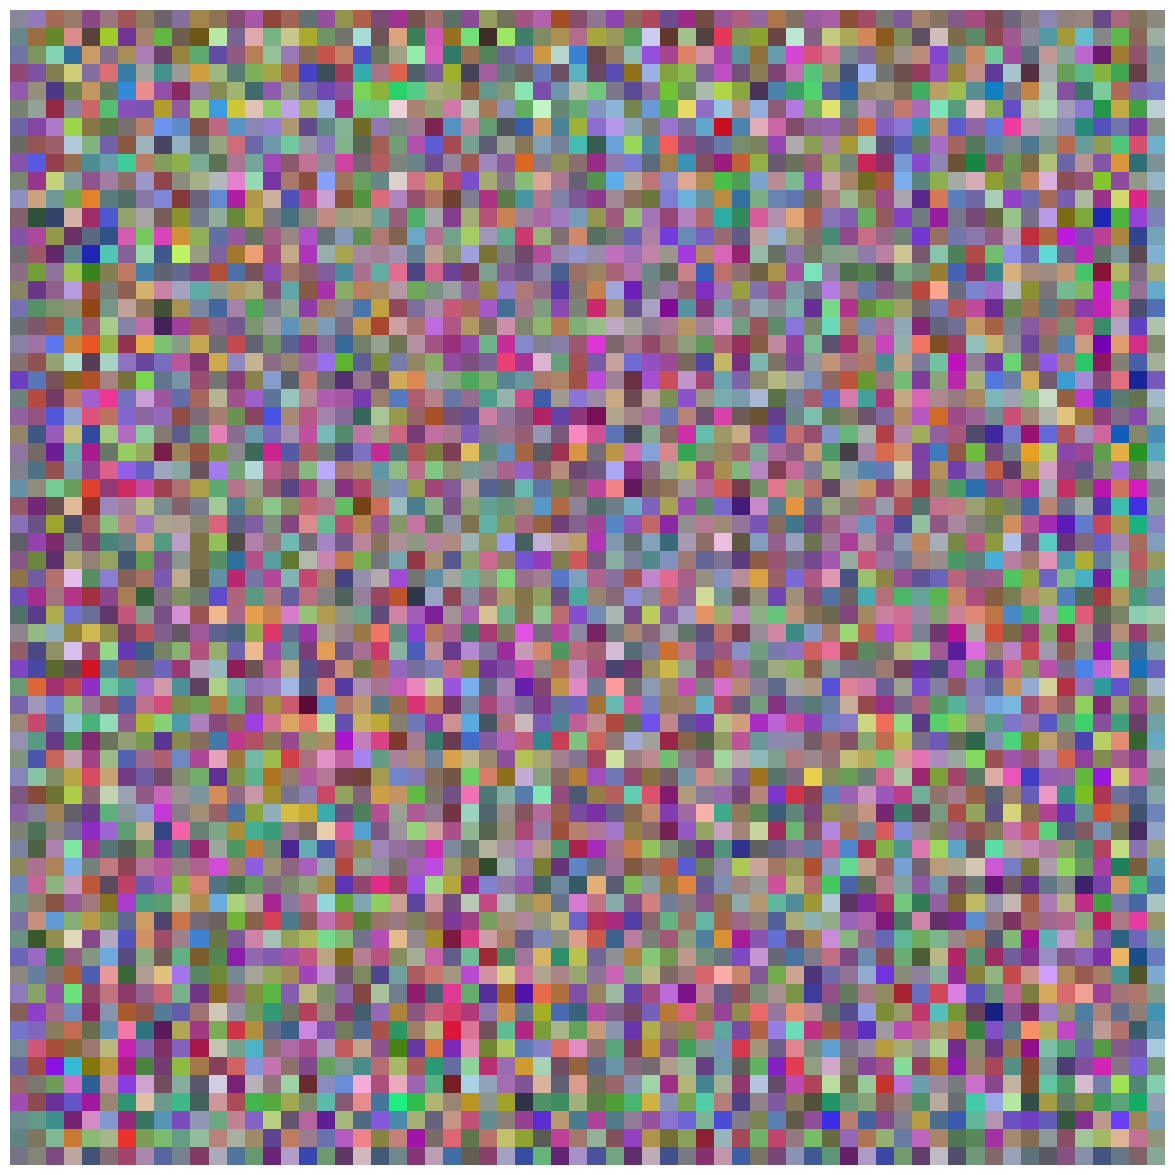

In [24]:
### CLIENT ###
with open('{}/gen'.format(collection), 'rb') as f:
    gen = pickle.load(f)
with torch.no_grad():
    no_grad_fake = gen(torch.randn(64, 100, 1, 1, device=torch.device("cuda" if (torch.cuda.is_available() and 1 > 0) else "cpu"))).detach().cpu()
img_grid_fake = vutils.make_grid(no_grad_fake[:1], normalize=True)
save_image(img_grid_fake, 'tmp.png')
img = cv2.imread('tmp.png', cv2.IMREAD_UNCHANGED)
width = 150
height = 150
dim = (width, height)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
cv2.imwrite('tmp.png', resized)
plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(np.transpose(img_grid_fake,(1,2,0)))
plt.show()
plt.close()